In [1]:
import torch
import yaml
import numpy as np
import pytorch_lightning

from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

In [2]:
# Model to plot
model_dir = "/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/feedforwardmask_synthetic_continual_er_1111_1.0/feedforwardmask/version_0"
model = model_dir.split("/")[3]
memory = model_dir.split("/")[2].split("_")[-1]
cfg_dir = f"{model_dir}/task_0/hparams.yaml"

with open(cfg_dir, 'r') as stream:
    cfg = yaml.safe_load(stream)
print(cfg)

{'accelerator': 'gpu', 'devices': [1], 'num_workers': 0, 'seed': 1111, 'exptag': '', 'gradual_percent': 1.0, 'exptype': 'feedforwardmask_synthetic_continual_er_1111_1.0', 'model_path': '', 'checkpt': '', 'save_files': True, 'model': 'feedforwardmask', 'stochastic': True, 'meta': True, 'dataset': 'synthetic', 'dataset_ver': 'scar_', 'task_ids': [13, 16, 3, 0, 2, 5, 1, 7, 15], 'data_names': ['AW', 'DC', 'EC'], 'signal_type': 'egm', 'seq_len': 101, 'graph_method': 'bipartite', 'load_torso': 0, 'load_physics': 0, 'signal_source': 'heart', 'omit': 5, 'window': 60, 'task_setting': 'continual', 'num_updates_steps': 2000, 'num_task_steps': 2050, 'log_interval': 50, 'val_log_interval': 50, 'memory_name': 'er', 'known_boundary': True, 'boundary_detection': False, 'latent_dim': 64, 'latent_act': 'swish', 'num_layers': 1, 'num_hidden': 64, 'code_dim': 12, 'num_filters': [1, 8, 16, 32, 64, 128, 256], 'metrics': ['mse', 'tcc', 'scc'], 'batch_size': 10, 'domain_size': 5, 'domain_varying': True, 'grad

In [3]:
# Iterate over task ids and stack datasets
npzfile = np.load(f"../data/synthetic/scar_15/train.npz")

# Load in data sources
xs = npzfile['xs']
xs = np.swapaxes(xs, 2, 1)

xs = xs[:, :, :60]
xs = xs[:, :, 5:]

labels = npzfile['label'].astype(int)
scar = npzfile['scar']
names = npzfile['heart_name']
print(xs.shape)


(44, 480, 55)


In [4]:
xs_gt = np.load("/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/feedforwardmask_synthetic_continual_er_1111_1.0/feedforwardmask/version_0/task_8/test_8_train/test_8_train_signals.npy", allow_pickle=True)
xs_pred = np.load("/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/feedforwardmask_synthetic_continual_er_1111_1.0/feedforwardmask/version_0/task_8/test_8_train/test_8_train_preds.npy", allow_pickle=True)
print(xs_gt.shape, xs_pred.shape)

(44, 480, 55) (44, 480, 55)


In [5]:
import os
import torch
import pickle
import numpy as np
import scipy.io

from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset

from torch_geometric.data import Data


class HeartEmptyGraphDataset(Dataset):
    """
    A dataset of Data objects (in pytorch geometric) with graph attributes
    from a pre-defined graph hierarchy. The features and target values are 
    set to zeros in given graph.
    Not suitable for training.
    """

    def __init__(self,
                 mesh_graph,
                 label_type=None):
        self.graph = mesh_graph
        dim = self.graph.pos.shape[0]
        self.datax = np.zeros((dim, 101))
        self.label = np.zeros((101))

    def __len__(self):
        return (self.datax.shape[1])

    def __getitem__(self, idx):
        x = torch.from_numpy(self.datax[:, [idx]]).float()  # torch.tensor(dataset[:,[i]],dtype=torch.float)
        y = torch.from_numpy(self.label[[idx]]).float()  # torch.tensor(label_aha[[i]],dtype=torch.float)

        sample = Data(x=x,
                      y=y,
                      edge_index=self.graph.edge_index,
                      edge_attr=self.graph.edge_attr,
                      pos=self.graph.pos)
        return sample


def load_graph(filename, load_torso=0, graph_method=None):
    with open(filename + '.pickle', 'rb') as f:
        g = pickle.load(f)
        g1 = pickle.load(f)
        g2 = pickle.load(f)
        g3 = pickle.load(f)
        g4 = pickle.load(f)

        P10 = pickle.load(f)
        P21 = pickle.load(f)
        P32 = pickle.load(f)
        P43 = pickle.load(f)

        if load_torso == 1:
            t_g = pickle.load(f)
            t_g1 = pickle.load(f)
            t_g2 = pickle.load(f)
            t_g3 = pickle.load(f)

            t_P10 = pickle.load(f)
            t_P21 = pickle.load(f)
            t_P32 = pickle.load(f)

            if graph_method == 'bipartite':
                Hs = pickle.load(f)
                Ps = pickle.load(f)
            else:
                raise NotImplementedError

    if load_torso == 0:
        P01 = P10 / P10.sum(axis=0)
        P12 = P21 / P21.sum(axis=0)
        P23 = P32 / P32.sum(axis=0)
        P34 = P43 / P43.sum(axis=0)

        P01 = torch.from_numpy(np.transpose(P01)).float()
        P12 = torch.from_numpy(np.transpose(P12)).float()
        P23 = torch.from_numpy(np.transpose(P23)).float()
        P34 = torch.from_numpy(np.transpose(P34)).float()

        P10 = torch.from_numpy(P10).float()
        P21 = torch.from_numpy(P21).float()
        P32 = torch.from_numpy(P32).float()
        P43 = torch.from_numpy(P43).float()

        return g, g1, g2, g3, g4, P10, P21, P32, P43, P01, P12, P23, P34
    elif load_torso == 1:
        t_P01 = t_P10 / t_P10.sum(axis=0)
        t_P12 = t_P21 / t_P21.sum(axis=0)
        t_P23 = t_P32 / t_P32.sum(axis=0)

        t_P01 = torch.from_numpy(np.transpose(t_P01)).float()
        t_P12 = torch.from_numpy(np.transpose(t_P12)).float()
        t_P23 = torch.from_numpy(np.transpose(t_P23)).float()

        if graph_method == 'bipartite':
            Ps = torch.from_numpy(Ps).float()
        else:
            raise NotImplementedError

        P10 = torch.from_numpy(P10).float()
        P21 = torch.from_numpy(P21).float()
        P32 = torch.from_numpy(P32).float()
        P43 = torch.from_numpy(P43).float()

        return g, g1, g2, g3, g4, P10, P21, P32, P43,\
            t_g, t_g1, t_g2, t_g3, t_P01, t_P12, t_P23, Hs, Ps


def get_params(data_path, heart_name, device, batch_size, load_torso=0, load_physics=0, graph_method=None):
    if load_physics == 1:
        # Load physics parameters
        physics_name = heart_name.split('_')[0]
        physics_dir = os.path.join(data_path, 'physics/{}/'.format(physics_name))
        mat_files = scipy.io.loadmat(os.path.join(physics_dir, 'h_L.mat'), squeeze_me=True, struct_as_record=False)
        L = mat_files['h_L']

        mat_files = scipy.io.loadmat(os.path.join(physics_dir, 'H.mat'), squeeze_me=True, struct_as_record=False)
        H = mat_files['H']

        L = torch.from_numpy(L).float().to(device)
        print('Load Laplacian: {} x {}'.format(L.shape[0], L.shape[1]))

        H = torch.from_numpy(H).float().to(device)
        print('Load H matrix: {} x {}'.format(H.shape[0], H.shape[1]))

    # Load geometrical parameters
    graph_file = os.path.join(data_path, 'signal/{}/{}_{}'.format(heart_name, heart_name, graph_method))
    if load_torso == 0:
        g, g1, g2, g3, g4, P10, P21, P32, P43, P01, P12, P23, P34 = \
            load_graph(graph_file, load_torso, graph_method)
    else:
        g, g1, g2, g3, g4, P10, P21, P32, P43,\
        t_g, t_g1, t_g2, t_g3, t_P01, t_P12, t_P23, Hs, Ps = load_graph(graph_file, load_torso, graph_method)

    num_nodes = [g.pos.shape[0], g1.pos.shape[0], g2.pos.shape[0], g3.pos.shape[0],
                 g4.pos.shape[0]]
    # print('number of nodes:', num_nodes)

    g_dataset = HeartEmptyGraphDataset(mesh_graph=g)
    g_loader = DataLoader(g_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    bg = next(iter(g_loader))

    g1_dataset = HeartEmptyGraphDataset(mesh_graph=g1)
    g1_loader = DataLoader(g1_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    bg1 = next(iter(g1_loader))

    g2_dataset = HeartEmptyGraphDataset(mesh_graph=g2)
    g2_loader = DataLoader(g2_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    bg2 = next(iter(g2_loader))

    g3_dataset = HeartEmptyGraphDataset(mesh_graph=g3)
    g3_loader = DataLoader(g3_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    bg3 = next(iter(g3_loader))

    g4_dataset = HeartEmptyGraphDataset(mesh_graph=g4)
    g4_loader = DataLoader(g4_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    bg4 = next(iter(g4_loader))

    P10 = P10.to(device)
    P21 = P21.to(device)
    P32 = P32.to(device)
    P43 = P43.to(device)

    bg1 = bg1.to(device)
    bg2 = bg2.to(device)
    bg3 = bg3.to(device)
    bg4 = bg4.to(device)

    bg = bg.to(device)

    if load_torso == 0:
        P01 = P01.to(device)
        P12 = P12.to(device)
        P23 = P23.to(device)
        P34 = P34.to(device)

        P1n = np.ones((num_nodes[1], 1))
        Pn1 = P1n / P1n.sum(axis=0)
        Pn1 = torch.from_numpy(np.transpose(Pn1)).float()
        P1n = torch.from_numpy(P1n).float()
        P1n = P1n.to(device)
        Pn1 = Pn1.to(device)

        params = {
            "bg1": bg1, "bg2": bg2, "bg3": bg3, "bg4": bg4,
            "P01": P01, "P12": P12, "P23": P23, "P34": P34,
            "P10": P10, "P21": P21, "P32": P32, "P43": P43,
            "P1n": P1n, "Pn1": Pn1, "num_nodes": num_nodes, "g": g, "bg": bg
        }
    elif load_torso == 1:
        t_num_nodes = [t_g.pos.shape[0], t_g1.pos.shape[0], t_g2.pos.shape[0], t_g3.pos.shape[0]]
        print('number of nodes on torso:', t_num_nodes)
        t_g_dataset = HeartEmptyGraphDataset(mesh_graph=t_g)
        t_g_loader = DataLoader(t_g_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        t_bg = next(iter(t_g_loader))

        t_g1_dataset = HeartEmptyGraphDataset(mesh_graph=t_g1)
        t_g1_loader = DataLoader(t_g1_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        t_bg1 = next(iter(t_g1_loader))

        t_g2_dataset = HeartEmptyGraphDataset(mesh_graph=t_g2)
        t_g2_loader = DataLoader(t_g2_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        t_bg2 = next(iter(t_g2_loader))

        t_g3_dataset = HeartEmptyGraphDataset(mesh_graph=t_g3)
        t_g3_loader = DataLoader(t_g3_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        t_bg3 = next(iter(t_g3_loader))

        t_P01 = t_P01.to(device)
        t_P12 = t_P12.to(device)
        t_P23 = t_P23.to(device)

        t_bg1 = t_bg1.to(device)
        t_bg2 = t_bg2.to(device)
        t_bg3 = t_bg3.to(device)
        t_bg = t_bg.to(device)

        if graph_method == 'bipartite':
            H_dataset = HeartEmptyGraphDataset(mesh_graph=Hs)
            H_loader = DataLoader(H_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
            H_inv = next(iter(H_loader))

            H_inv = H_inv.to(device)
            Ps = Ps.to(device)

            if load_physics == 1:
                params = {
                    "bg1": bg1, "bg2": bg2, "bg3": bg3, "bg4": bg4,
                    "P10": P10, "P21": P21, "P32": P32, "P43": P43,
                    "num_nodes": num_nodes, "g": g, "bg": bg,
                    "t_bg1": t_bg1, "t_bg2": t_bg2, "t_bg3": t_bg3,
                    "t_P01": t_P01, "t_P12": t_P12, "t_P23": t_P23,
                    "t_num_nodes": t_num_nodes, "t_g": t_g, "t_bg": t_bg,
                    "H_inv": H_inv, "P": Ps,
                    "H": H, "L": L
                }
            else:
                params = {
                    "bg1": bg1, "bg2": bg2, "bg3": bg3, "bg4": bg4,
                    "P10": P10, "P21": P21, "P32": P32, "P43": P43,
                    "num_nodes": num_nodes, "g": g, "bg": bg,
                    "t_bg1": t_bg1, "t_bg2": t_bg2, "t_bg3": t_bg3,
                    "t_P01": t_P01, "t_P12": t_P12, "t_P23": t_P23,
                    "t_num_nodes": t_num_nodes, "t_g": t_g, "t_bg": t_bg,
                    "H_inv": H_inv, "P": Ps
                }
        else:
            raise NotImplementedError

    return params


/tmp/ipykernel_4147924/4090612596.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


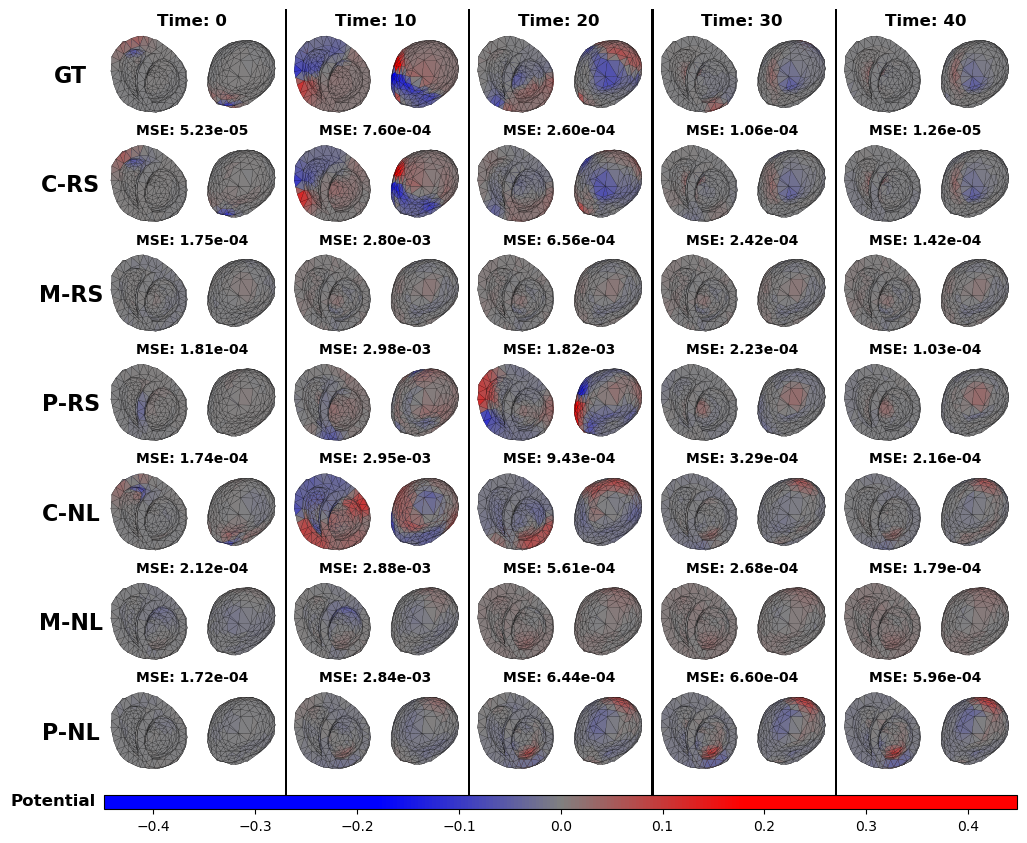

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def create_mesh_faces(edge_index):
    """Create triangular faces from edge connections"""
    # Convert edge indices to set of edges for faster lookup
    edges = set()
    for i in range(edge_index.shape[1]):
        v1, v2 = sorted([int(edge_index[0,i]), int(edge_index[1,i])])
        edges.add((v1, v2))
    
    # Find triangles by checking edge connections
    faces = []
    for e1 in edges:
        for v3 in range(edge_index.max().item() + 1):
            # Check if v3 forms a triangle with edge e1
            e2 = tuple(sorted([e1[1], v3]))
            e3 = tuple(sorted([e1[0], v3]))
            if e2 in edges and e3 in edges:
                face = tuple(sorted([e1[0], e1[1], v3]))
                faces.append(face)
    
    return np.array(list(set(faces)))


def visualize_potential_comparison(data, params, timeframes=[0, 25, 50, 75], figsize=(20, 12)):
    """
    Visualize ground truth and multiple predictions in separate rows with MSE values in titles
    """
    # Get positions and edge indices from params
    positions = params['g'].pos.numpy()
    edge_index = params['g'].edge_index.numpy()
    faces = create_mesh_faces(edge_index)
    
    gt_data = data.pop("GT")  # Remove GT from data dict to handle separately
    n_rows = len(data) + 1  # GT + number of baselines
    n_views = 2  # Top and bottom views
    
    # Create figure with subplots and space for colorbar
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(n_rows + 1, len(timeframes)*n_views + 1,
                     height_ratios=[1]*n_rows + [0.15],
                     width_ratios=[0.15] + [1]*(len(timeframes)*n_views),
                     hspace=0.2,
                     wspace=0.05)

    # Create custom colormap with nonlinear color transitions
    potential_colors = ['#0000FF', '#0000FF', '#808080', '#FF0000', '#FF0000']
    potential_positions = [0.0, 0.3, 0.5, 0.7, 1.0]
    
    n_bins = 256
    potential_cmap = colors.LinearSegmentedColormap.from_list("potential", 
                                                            list(zip(potential_positions, potential_colors)), 
                                                            N=n_bins)
    
    # Find global min/max across all data
    all_potentials = np.concatenate([gt_data] + list(data.values()), axis=1)
    vmin, vmax = np.min(all_potentials), np.max(all_potentials)
    abs_max = max(abs(vmin), abs(vmax))
    potential_norm = colors.Normalize(vmin=-abs_max, vmax=abs_max)
    
    # Calculate MSE per timeframe for each baseline
    mse_values = {}
    for method in data.keys():
        mse_values[method] = np.zeros(len(timeframes))
        for i, t in enumerate(timeframes):
            mse_values[method][i] = np.mean((gt_data[:, t] - data[method][:, t])**2)
    
    # Views configuration
    views = [
        {'elev': 90, 'azim': 0},  # Top-down view
        {'elev': -90, 'azim': 0}  # Bottom-up view
    ]
    
    # Create ordered list of rows starting with GT
    rows = [("GT", gt_data)] + [(method, pred) for method, pred in data.items()]
    
    for row_idx, (label, potentials) in enumerate(rows):
        # Add row label
        label_ax = fig.add_subplot(gs[row_idx, 0])
        label_ax.text(-1.25, 0.5, label, rotation=0,
                     horizontalalignment='center', verticalalignment='center',
                     fontsize=16, fontdict={'fontweight': 'bold'})
        label_ax.axis('off')
        
        for t_idx, t in enumerate(timeframes):
            for v_idx, view in enumerate(views):
                col_idx = t_idx * n_views + v_idx + 1
                
                ax = fig.add_subplot(gs[row_idx, col_idx], projection='3d')
                
                # Create mesh with current timeframe data
                mesh_vertices = positions[faces]
                face_colors = np.mean(potentials[:, t][faces], axis=1)
                
                mesh = Poly3DCollection(mesh_vertices, 
                                      facecolors=potential_cmap(potential_norm(face_colors)))
                mesh.set_edgecolor('black')
                mesh.set_linewidth(0.1)
                ax.add_collection3d(mesh)
        
                # Set axis limits and scaling
                x_range = positions[:, 0].max() - positions[:, 0].min()
                y_range = positions[:, 1].max() - positions[:, 1].min()
                z_range = positions[:, 2].max() - positions[:, 2].min()
                
                x_center = (positions[:, 0].max() + positions[:, 0].min()) / 2
                y_center = (positions[:, 1].max() + positions[:, 1].min()) / 2
                z_center = (positions[:, 2].max() + positions[:, 2].min()) / 2
                
                scale_factor = 0.35
                ax.set_xlim(x_center - x_range*scale_factor, x_center + x_range*scale_factor)
                ax.set_ylim(y_center - y_range*scale_factor, y_center + y_range*scale_factor)
                ax.set_zlim(z_center - z_range*scale_factor, z_center + z_range*scale_factor)
                
                ax.set_box_aspect([1, 1, 1])
                ax.set_axis_off()
                ax.grid(False)
                
                ax.view_init(elev=view['elev'], azim=view['azim'])
                
                # Set titles only on first view of each pair
                if v_idx == 0:
                    if row_idx == 0:  # Ground Truth row
                        ax.set_title(f'Time: {t}', pad=5, x=1, fontsize=12, 
                                   fontdict={'fontweight': 'bold'})
                    else:  # Baseline rows
                        method = label
                        ax.set_title(f'MSE: {mse_values[method][t_idx]:.2e}', 
                                   pad=5, x=1, fontsize=10,
                                   fontdict={'fontweight': 'bold'})

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1, hspace=0.4, wspace=0.1)
    
    # Add separator lines between timeframe pairs
    for t_idx in range(len(timeframes)-1):
        # Get position of current pair's second view
        current_ax = fig.axes[1 + t_idx*2]  # Skip label axes and get second view
        next_ax = fig.axes[2 + (t_idx+1)*2]  # Get first view of next pair
        
        # Calculate separator position
        current_pos = current_ax.get_position()
        next_pos = next_ax.get_position()
        sep_x = (current_pos.x1 + next_pos.x0) / 2
        
        # Add separator line for both rows
        for row in range(2):
            ax_sep = fig.add_axes([sep_x - 0.001, 0.1, 0.002, 0.8])  # [x, y, width, height]
            ax_sep.axvspan(0, 1, color='black')
            ax_sep.axis('off')
    
    # Add colorbar
    sm_potential = plt.cm.ScalarMappable(cmap=potential_cmap, norm=potential_norm)
    cbar_ax = fig.add_subplot(gs[-1, 1:])
    cbar = plt.colorbar(sm_potential, cax=cbar_ax, orientation='horizontal')
    cbar_ax.set_title('Potential', y=0, x=-0.01, rotation=0, ha='right', va='center', fontweight='bold')
    
    plt.savefig("ClusterMeshFigure.png", dpi=300)
    plt.show()


# Choose base task
idx = 0
base_task = 8
test_task = 0
pred_path = f"task_{base_task}/test_{test_task}_train/test_{test_task}_train_preds.npy"

# Data samples to use
data = {
    "GT": np.load(f"/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/feedforwardmask_synthetic_continual_er_1111_1.0/feedforwardmask/version_0/task_{base_task}/test_{test_task}_train/test_{test_task}_train_signals.npy", allow_pickle=True)[idx],
    
    "C-RS": np.load(f"/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/feedforwardmask_synthetic_continual_task_aware_1111_1.0/feedforwardmask/version_0/{pred_path}", allow_pickle=True)[idx],
    "M-RS": np.load(f"/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/maml_synthetic_continual_task_aware_1111_1.0/maml/version_3/{pred_path}", allow_pickle=True)[idx],
    "P-RS": np.load(f"/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/pns_synthetic_continual_task_aware_1111_1.0/pns/version_0/{pred_path}", allow_pickle=True)[idx],
    
    "C-NL": np.load(f"/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/feedforwardmask_synthetic_continual_naive_1111_1.0/feedforwardmask/version_0/{pred_path}", allow_pickle=True)[idx],
    "M-NL": np.load(f"/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/maml_synthetic_continual_naive_1111_1.0/maml/version_0/{pred_path}", allow_pickle=True)[idx],
    "P-NL": np.load(f"/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/pns_synthetic_continual_naive_1111_1.0/pns/version_0/{pred_path}", allow_pickle=True)[idx],
}

# Set up params based on test task
param_dict = {
    480: "AW",
    475: "DC",
    448: "EC"
}

params = get_params("../data/ep/", param_dict[data["GT"].shape[0]], cfg['devices'][0], 1, cfg['load_torso'], cfg['load_physics'], cfg['graph_method'])      

# Example usage:
timeframes = [0, 10, 20, 30, 40]
visualize_potential_comparison(data, params, timeframes, figsize=(12, 10))